<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> KNN Classification</p>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>🧠 Algorithm Intuition:</font></h3>

<ul>
    <li><i>K Nearest Neighbours</i> assigns class labels to a sample based on the y (class) labels of the samples that are most similar to it. The algorithm considers distance between x as the determinant of similarity, relying on <i>k</i> of the closest samples to perform a majority vote for the class that is most probable.</li>
    <li>The method is considered a "lazy learner" in that it doesn't build a model from the training data. Instead, it does very little during the training (or "fit") phase other than store the x array and <i>y</i> vector. This is in contrast to an "eager learner" that builds a model with learned parameters during training. For lazy leaners, it is in fact during the prediction (or "predict") phase that the computation takes place.

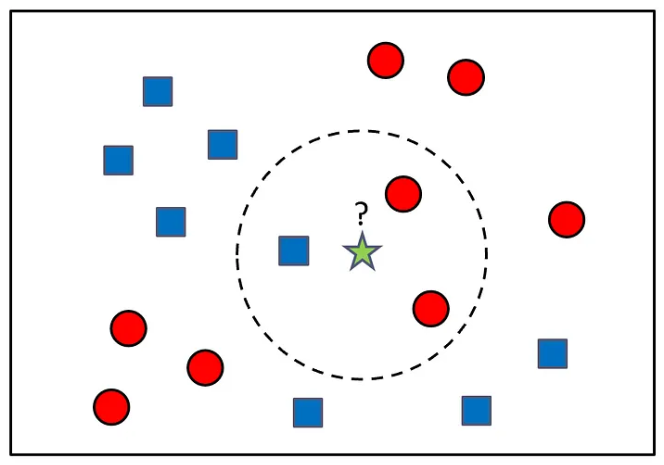

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

For KNN, the high level algorith during prediction is the following:
    <ul>
        <li>from the training dataset defined as <i>D</i> = {(x₁, <i>y₁</i>), (x₂, <i>y₂</i>), … , (xₙ, <i>yₙ</i>)} where xᵢ is each observation within the X array and <i>yᵢ</i> is the corresponding label / class, calculate the distance between xᵢ and a given sample x.</i>
        <li>ordered by asceding distance, take the top k of xᵢ (and corresponding <i>yᵢ</i>) to form a new subset <i>N</i> of <i>D</i>
        <li>Retrieve majority class <i>c</i> among <i>yᵢ</i>.</li>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>⚖ Weighted Voting</font></h3>

<ul>
    <li>Distance is most commonly calculated using Euclidian distance, given by the formula below</li>
</ul>
</div>


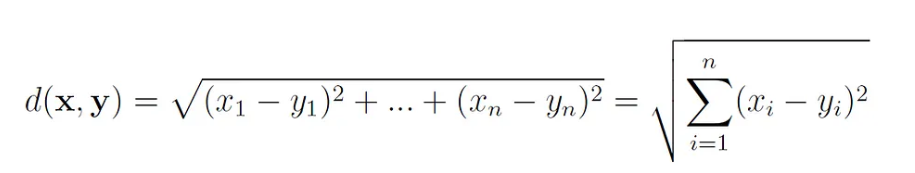

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<ul>
    <li>Without weighting, each of the <i>k</i> nearest neighbours has an equal vote (i.e. 1). However, often the nearest samples indicate its class more reliably. Weighting samples based on their distance so that closer samples have a stronger say in what class the new sample should be is appropriate in many situations. The most common way to express weights for the <i>k</i> nearest neighbours is to take the inverse of the distance, as follows: </li>
</ul>
</div>


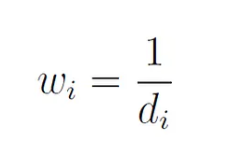

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<ul>
    <li>With the inverses calculted, the predicted y label is the class that maximises the summed inverses (now "says") for the samples within the <i>k</i> nearest neighbours, rather than just the class that maximised an equal vote.</li>
</ul>
</div>


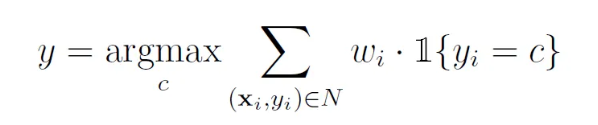

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<ul>
    <li>To learn more (requires membership): https://medium.com/@roiyeho/k-nearest-neighbors-knn-a-comprehensive-guide-7add717806ad</li>
</ul>
</div>


*Import Libraries*

In [37]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

*Supress warnings*

In [12]:
# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [3]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [20]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

In [22]:
# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [23]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [24]:
# create model
model_knn = KNeighborsClassifier() # default n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'

# create sklearn pipeline
pipeline_knn = settings.create_pipeline(["preprocess", column_trans], ["knn_classifier", model_knn])

# create cross validation object for cross_val_score
cv_knn = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_knn, X_train, y_train, scoring='accuracy', cv=cv_knn)
print('Mean CV Train Accuracy:', settings.score_formatter(np.mean(cv_scores), 4))
print('Max CV Train Accuracy:', settings.score_formatter(np.max(cv_scores), 4))
print('Min CV Train Accuracy:', settings.score_formatter(np.min(cv_scores), 4))
print('Std CV Train Accuracy:', settings.score_formatter(np.std(cv_scores), 4))

# fit pipeline and produce test score 
pipeline_knn.fit(X_train, y_train)
test_acc = pipeline_knn.score(X_test, y_test)
print('Test Accuracy:', settings.score_formatter(test_acc, 4))

Mean CV Train Accuracy: 87.5000 %
Max CV Train Accuracy: 96.1500 %
Min CV Train Accuracy: 80.7700 %
Std CV Train Accuracy: 4.2600 %
Test Accuracy: 92.9200 %


Average train score across seeds: 91.800 %
Average cv train score across seeds: 89.300 %
Average test score across seeds: 88.200 %


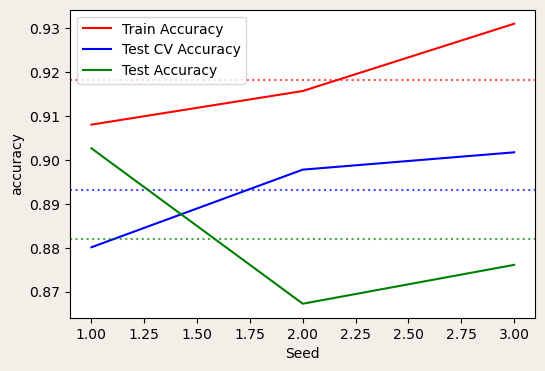

In [65]:
# large variability observed across folds. Explore impact of chosen seed.


def plot_seed_variability(X, y, test_size, num_seeds, pipeline_or_model, scoring, cv_object):
    """
    Evaluate and visualize the variability of model performance across different random seeds.

    This function splits the provided dataset into train and test subsets using different random seeds.
    It then trains a given model or pipeline on the training data, computes train and test accuracies,
    as well as cross-validation scores. The function produces a plot showcasing the trend of these scores
    across different seeds.

    Parameters:
    X (array-like): The feature matrix.
    y (array-like): The target vector.
    test_size (float): The proportion of the dataset to include in the test split.
    num_seeds (int): The number of random seeds to consider.
    pipeline_or_model: The machine learning model or pipeline to evaluate.
    scoring (str): The scoring metric for cross-validation and accuracy evaluation.
    cv_object: The cross-validation strategy, compatible with the `cross_val_score` function.

    Returns:
    None
        The function prints the average train, cross-validation, and test accuracy scores across seeds,
        and displays a plot illustrating the performance variability.
    """
    train_cv_dict = {}
    train_dict = {}
    test_dict = {}
    num_seeds = 3

    for i in np.arange(1, num_seeds + 1):
        # re-split using seed
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
        # Reshape y vector
        y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)
        # run training cv score and add to dict
        cv_scores = cross_val_score(pipeline_knn, X_train, y_train, scoring=scoring, cv=cv_object)
        train_cv_dict[i] = cv_scores.mean()
        # fit pipeline, score on test and add to dict
        pipeline_knn.fit(X_train, y_train)
        train_accuracy = pipeline_knn.score(X_train, y_train)
        test_accuracy = pipeline_knn.score(X_test, y_test)
        train_dict[i] = train_accuracy
        test_dict[i] = test_accuracy

    # present average train and test accuracy scores across all seeds
    print("Average train score across seeds:", settings.score_formatter(np.mean(list(train_dict.values())),3))
    print("Average cv train score across seeds:", settings.score_formatter(np.mean(list(train_cv_dict.values())),3))
    print("Average test score across seeds:", settings.score_formatter(np.mean(list(test_dict.values())),3))

    # plot results
    fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
    ax.plot(np.arange(1, num_seeds + 1), train_dict.values(), color="r", label="Train Accuracy")
    ax.axhline(y=np.mean(list(train_dict.values())), color='r', linestyle='dotted', alpha=0.7)
    ax.plot(np.arange(1,num_seeds + 1), train_cv_dict.values(), color="b", label="Test CV Accuracy")
    ax.axhline(y=np.mean(list(train_cv_dict.values())), color='b', linestyle='dotted', alpha=0.7)
    ax.plot(np.arange(1,num_seeds + 1), test_dict.values(), color="g", label="Test Accuracy")
    ax.axhline(y=np.mean(list(test_dict.values())), color='g', linestyle='dotted', alpha=0.7)
    ax.set_ylabel(scoring)
    ax.set_xlabel("Seed")
    ax.legend()
    plt.show()

plot_seed_variability(X=X, y=y, test_size=0.3, num_seeds=3, pipeline_or_model=pipeline_knn, scoring="accuracy", cv_object=cv_knn)



Average train score across seeds: 91.800 %
Average cv train score across seeds: 89.300 %
Average test score across seeds: 88.200 %


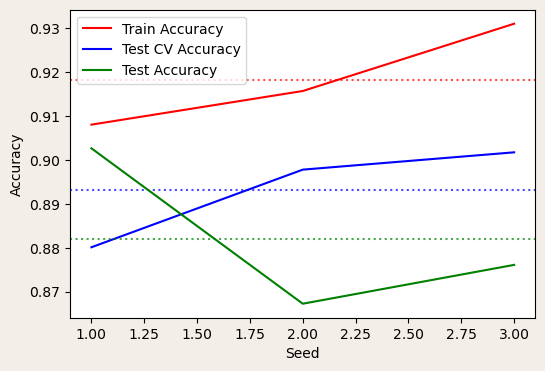

In [56]:
# present average train and test accuracy scores across all seeds
print("Average train score across seeds:", settings.score_formatter(np.mean(list(train_dict.values())),3))
print("Average cv train score across seeds:", settings.score_formatter(np.mean(list(train_cv_dict.values())),3))
print("Average test score across seeds:", settings.score_formatter(np.mean(list(test_dict.values())),3))

# plot results
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
ax.plot(np.arange(1, num_seeds + 1), train_dict.values(), color="r", label="Train Accuracy")
ax.axhline(y=np.mean(list(train_dict.values())), color='r', linestyle='dotted', alpha=0.7)
ax.plot(np.arange(1,num_seeds + 1), train_cv_dict.values(), color="b", label="Test CV Accuracy")
ax.axhline(y=np.mean(list(train_cv_dict.values())), color='b', linestyle='dotted', alpha=0.7)
ax.plot(np.arange(1,num_seeds + 1), test_dict.values(), color="g", label="Test Accuracy")
ax.axhline(y=np.mean(list(test_dict.values())), color='g', linestyle='dotted', alpha=0.7)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Seed")
ax.legend()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Good baseline model train cv accuracy ~ 87% and higher test accuracy ~93%</li>
    <li>High variation in cv accuracy scores: between 80 and 94%!</li> 
    <li>High dependance on data split which itself depends on the random seed: reason for why test is higher than train. As seen in the last graph, varying the random seed 20 times results in occassions where train cv accuracy is higher than test score, and vise versa. Overall, train averages at 89.1% and test at 88.5%</li>
</ul>
</div>


In [18]:
# reset split to same seed as beginning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Re-encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)
# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

In [19]:
# Save baseline pipeline to file  
settings.save_pipeline("best_knn_classification_pipeline.pkl", pipeline_knn)

*Hyperparam tuning*

*Smoothing*

In [25]:
# Define the parameter grid
param_grid_knn = {
    'knn_classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],     # List of values for n_neighbors
    'knn_classifier__weights': ['uniform', 'distance'],  # List of values for weights
    'knn_classifier__p': [1, 2],                  # List of values for p
    'knn_classifier__metric': ['euclidean', 'manhattan']  # List of values for metric
}

# Create and fit GridSearchCV object on train data
grid_search_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, scoring='accuracy', cv=cv_knn, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Access best hyperparameters and accuracy score
best_params, best_train_score = grid_search_knn.best_params_, grid_search_knn.best_score_

# Print the best parameters
display("Best Parameters:", pd.DataFrame(best_params, index=[0]))

# Print the best mean cv training score
print("Mean CV Train Accuracy with best parameters:", settings.score_formatter(best_train_score, 4))

# Evaluate the best model on the test set
best_pipeline = grid_search_knn.best_estimator_
test_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy with best parameters:", settings.score_formatter(test_accuracy, 4))


'Best Parameters:'

,knn_classifier__metric,knn_classifier__n_neighbors,knn_classifier__p,knn_classifier__weights
0,manhattan,3,1,uniform


Mean CV Train Accuracy with best parameters: 88.7800 %
Test Accuracy with best parameters: 94.6900 %


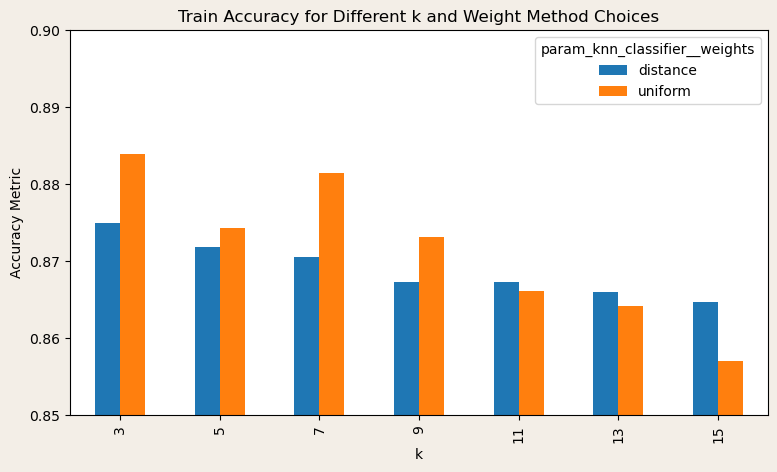

In [34]:
# Access the grid search results
results = grid_search_knn.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped.groupby(["param_knn_classifier__n_neighbors", "param_knn_classifier__weights"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.85, 0.9)
ax.set_xlabel('k')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different k and Weight Method Choices')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>model train cv accuracy improved to 88.7%</li>
    <li>Test accuracy improved to 94.7%</li> 
    <li>Different seeds would impact this as seen before, variability is high with this NB implementation: cause for consideration</li>
</ul>
</div>


*Review metrics for hypertuned model*

Test Accuracy: 92.9200 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.81      0.88      0.84        24
           2       0.90      0.83      0.86        23

    accuracy                           0.93       113
   macro avg       0.90      0.90      0.90       113
weighted avg       0.93      0.93      0.93       113



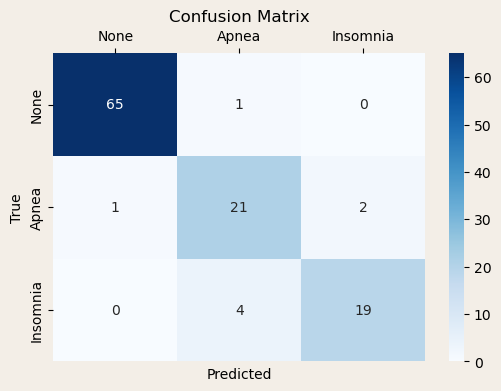

In [35]:
# Print test accuracy
pipeline_knn.fit(X_train, y_train)
print("Test Accuracy:", settings.score_formatter(pipeline_knn.score(X_test, y_test), 4))

# Generate prediction and show classification report
y_pred = pipeline_knn.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Model best at predicting None, with a very high precision and recall (98%)</li>
    <li>Apnea has the lower recall at 88% (3 incorrect out of test 24 instances) and lowest precision at 81%</li>
    <li>Insomnia has the lowest recall at 83% (4 incorrect out of 23 instances) but higher precision at 90%</li>
</ul>
</div>


*Addressing Class Imbalance: Exploring SMOTE-NC*

In [38]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_df, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [42]:
# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ("knn_classifier", model_knn)]
pipeline_knn = Pipeline_imb(steps)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_knn, X_train, y_train, scoring='accuracy', cv=cv_knn)
print('Mean CV Train Accuracy:', settings.score_formatter(np.mean(cv_scores), 4))
print('Max CV Train Accuracy:', settings.score_formatter(np.max(cv_scores), 4))
print('Min CV Train Accuracy:', settings.score_formatter(np.min(cv_scores), 4))
print('Std CV Train Accuracy:', settings.score_formatter(np.std(cv_scores), 4))

# fit pipeline and produce test score 
pipeline_knn.fit(X_train, y_train)
model_knn = pipeline_nb.named_steps['knn_classifier']
print('Train Accuracy:', settings.score_formatter(model_knn.score(transformed_X_train_df.values, y_train), 3))
print('Test Accuracy:', settings.score_formatter(model_knn.score(transformed_X_test_df.values, y_test), 3))


Mean CV Train Accuracy: 87.1100 %
Max CV Train Accuracy: 94.2300 %
Min CV Train Accuracy: 80.7700 %
Std CV Train Accuracy: 4.4700 %
Train Accuracy: 90.800 %
Test Accuracy: 93.800 %


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        66
           1       0.84      0.88      0.86        24
           2       0.84      0.91      0.87        23

    accuracy                           0.92       113
   macro avg       0.89      0.91      0.90       113
weighted avg       0.92      0.92      0.92       113



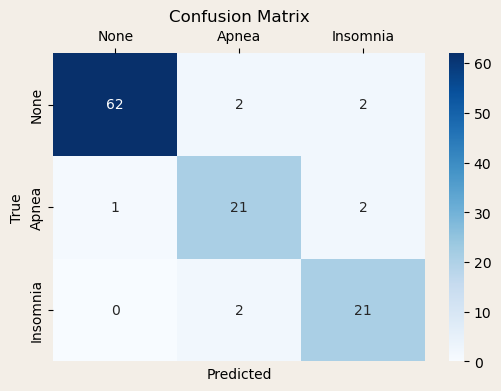

In [321]:
# Generate prediction and show classification report
y_pred = pipeline_nb.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>SMOTE shows no improvement</li>
</ul>
</div>
